In [58]:
from xgboost import XGBClassifier
import xgboost
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import stats

In [59]:
def preprocess_base_feature(df_or_path):
    if isinstance(df_or_path, str):
        df_or_path = pd.read_csv(df_or_path)
    df = df_or_path
    df['mean_degree'] = (df['u_degree'] + df['u_degree']).mean()   
    X = df.drop(["Unnamed: 0"], axis=1)
    return X

def preprocess_attributes(df_or_path):

    if isinstance(df_or_path, str):
        df_or_path = pd.read_csv(df_or_path)
    df = df_or_path
    df['sex_similar'] = df['sex_u'] == df['sex_v']
    df['age_diff'] = (df['age_u'] - df['age_v']).abs()
    X = df.drop(["Unnamed: 0"], axis=1)
    return X


def preprocess_factorization(dict_or_path):

    if isinstance(dict_or_path, str):
        dict_or_path = np.load(dict_or_path, allow_pickle=True)
    np_dict = dict_or_path
    np_dict['scores'] = np.maximum(np_dict['scores'], 0)
    return np_dict

def load_train_data(foler_base, folder_attr, folder_factorization, path_list, return_indexes=False, split=1):
    X_list = []
    y_list = []
    indexes_list = []
    precomputed_scores = []
    for path in tqdm(path_list):
        X_base = preprocess_base_feature(os.path.join(foler_base, path))
        X_attr = preprocess_attributes(os.path.join(folder_attr, path))
        X_factor = preprocess_factorization(os.path.join(folder_factorization, path.replace(".csv", '.pickle')))

        
        rich_X = X_base.merge(X_attr, on=['ego_id', 'u', 'v'])
        if split < 1:
            rich_X = rich_X.sample(frac = split)
        precomputed_u_v_score = X_factor['scores'][rich_X.u, rich_X.v]

        uv = precomputed_u_v_score
        vu = X_factor['scores'][rich_X.v, rich_X.u]
        mean = (uv + vu) / 2
        diff = np.abs(uv - vu)
        new_feats = np.stack([uv, vu, mean, diff], axis=1)
        new_feats = pd.DataFrame(new_feats, columns=["uv", 'vu', 'mean', 'diff'])
        
        X = rich_X.drop(["ego_id", 'x1', 'u', 'v'], axis=1)
        X[["uv", 'vu', 'mean', 'diff']] = new_feats
        assert len(precomputed_u_v_score) == len(X), (len(precomputed_u_v_score), len(X), X_factor['scores'].shape)
        
        names = X.columns.values.tolist()
        X = np.array(X.values).astype(np.float32)
        y = rich_X['x1']
        X_list.append(X)
        y_list.append(y)
        if return_indexes:
            indexes_list.append(rich_X[['ego_id', 'u','v']])
        precomputed_scores.append(precomputed_u_v_score)
    X = np.concatenate(X_list, axis=0)

    X[:,0] = np.log(X[:,0] + 10)
    X[:,4] = np.log(X[:,4] + 10)
    X[:,5] = np.log(X[:,5] + 10)
    X[:,11] = np.log(X[:,11] + 10)
    X[:,12] = np.log(X[:,12] + 10)
    X[:,15] = np.log(X[:,15] + 10)
    X[:,16] = np.log(X[:,16] + 10)
    X[:,24] = np.log(X[:,24] + 10)
    
    y = np.concatenate(y_list, axis=0)
    precomputed_scores = np.concatenate(precomputed_scores, axis=0)
    if return_indexes:
        return X, y, names, precomputed_scores, pd.concat(indexes_list)
    return X, y, names, precomputed_scores

In [60]:
import os
CSV_DIR = "updated_train"
CSV_ATTR_DIR = "train_csv"
PICKLE_FACTOR_DIR = "factorization_train"
train_count = 30000
test_count = 3000
train_files = os.listdir(CSV_DIR)[:train_count]

train_X, train_y, train_names, train_precomputed_scores = load_train_data(CSV_DIR, CSV_ATTR_DIR, PICKLE_FACTOR_DIR, train_files, split=0.3)
test_X, test_y, test_names, test_precomputed_scores = load_train_data("updated_train", "train_csv", "factorization_train", os.listdir(CSV_DIR)[train_count:train_count + test_count])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:53<00:00, 55.61it/s]


In [61]:
np.save("train_X.npy", train_X, allow_pickle=True, fix_imports=True)
np.save("train_y.npy", train_y, allow_pickle=True, fix_imports=True)
np.save("train_precomputed_scores.npy", train_precomputed_scores, allow_pickle=True, fix_imports=True)
np.save("test_X.npy", test_X, allow_pickle=True, fix_imports=True)
np.save("test_y.npy", test_y, allow_pickle=True, fix_imports=True)
np.save("test_precomputed_scores.npy", test_precomputed_scores, allow_pickle=True, fix_imports=True)
# train_X = np.load("train_X.npy")
# train_y = np.load("train_y.npy")
# test_X = np.load("test_X.npy")
# test_y = np.load("test_y.npy")
# train_precomputed_scores = np.load("train_precomputed_scores.npy")
# test_precomputed_scores = np.load("test_precomputed_scores.npy")

In [62]:
train_precomputed_scores.shape, train_X.shape, train_X.shape

((17843992,), (17843992, 29), (17843992, 29))

In [63]:
best_xgb_model = xgboost.XGBRegressor(
                gamma=0,                
                learning_rate=0.2,
                max_depth=8,
                n_estimators=150,
                booster='gbtree',
                colsample_bynode=1,
                seed=42,
                eval_metric=['rmse'],
                #sampling_method='gradient_based',
                objective='reg:squarederror',
                num_parallel_tree=20,
                subsample=0.8,
                tree_method='gpu_hist')

best_xgb_model.fit(train_X, train_y, 
                   base_margin=train_precomputed_scores * np.random.rand(len(train_precomputed_scores)), 
                   base_margin_eval_set=[test_precomputed_scores* np.random.rand(len(test_precomputed_scores))], eval_set=[(test_X, test_y)])

[0]	validation_0-rmse:1.20328
[1]	validation_0-rmse:1.05848
[2]	validation_0-rmse:0.95395
[3]	validation_0-rmse:0.88011
[4]	validation_0-rmse:0.82899
[5]	validation_0-rmse:0.79406
[6]	validation_0-rmse:0.77045
[7]	validation_0-rmse:0.75331
[8]	validation_0-rmse:0.74248
[9]	validation_0-rmse:0.73502
[10]	validation_0-rmse:0.72930
[11]	validation_0-rmse:0.72564
[12]	validation_0-rmse:0.72281
[13]	validation_0-rmse:0.72051
[14]	validation_0-rmse:0.71870
[15]	validation_0-rmse:0.71712
[16]	validation_0-rmse:0.71561
[17]	validation_0-rmse:0.71454
[18]	validation_0-rmse:0.71337
[19]	validation_0-rmse:0.71266
[20]	validation_0-rmse:0.71178
[21]	validation_0-rmse:0.71099
[22]	validation_0-rmse:0.71030
[23]	validation_0-rmse:0.70999
[24]	validation_0-rmse:0.70951
[25]	validation_0-rmse:0.70900
[26]	validation_0-rmse:0.70868
[27]	validation_0-rmse:0.70833
[28]	validation_0-rmse:0.70787
[29]	validation_0-rmse:0.70763
[30]	validation_0-rmse:0.70740
[31]	validation_0-rmse:0.70721
[32]	validation_0-

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=['rmse'], feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=20,
             predictor=None, random_state=None, ...)

In [64]:
# validation_0-rmse:0.75318 - 0.6
# validation_0-rmse:0.74838 - 0.4

In [65]:
reg = best_xgb_model.get_booster()

del train_X, train_y

In [8]:
from sklearn.metrics import mean_squared_error
y_pred = best_xgb_model.predict(test_X, base_margin=test_precomputed_scores)
print(mean_squared_error(test_y, y_pred, squared=False))

0.7116746627259314



del test_X, test_y

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

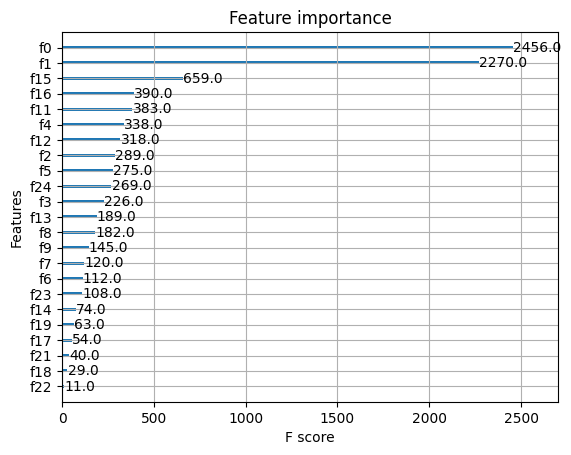

In [40]:
xgboost.plot_importance(reg)

In [10]:
import os
CSV_DIR = "updated_test"
assert len(os.listdir("updated_test")) == len(os.listdir("test_csv"))
eval_X, eval_y, names, eval_precomputed_scores, indexes = load_train_data("updated_test", "test_csv", "factorization_test", os.listdir("updated_test"), return_indexes=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20596/20596 [05:11<00:00, 66.14it/s]


In [66]:
import pickle
# np.save("eval_X.npy", eval_X, allow_pickle=True, fix_imports=True)
# np.save("eval_y.npy", eval_y, allow_pickle=True, fix_imports=True)
# np.save("eval_precomputed_scores.npy", eval_precomputed_scores, allow_pickle=True, fix_imports=True)
# with open("eval_indexes.pkl",'wb') as f:
#    pickle.dump(indexes, f)

eval_X = np.load("eval_X.npy")
eval_y = np.load("eval_y.npy")
eval_precomputed_scores = np.load("eval_precomputed_scores.npy")
train_y = np.load("train_y.npy")
with open("eval_indexes.pkl",'rb') as f:
   indexes = pickle.load(f)

In [67]:
y_pred = best_xgb_model.predict(eval_X, base_margin=eval_precomputed_scores)
print(mean_squared_error(eval_y[~np.isnan(eval_y)], y_pred[~np.isnan(eval_y)], squared=False))

0.6930746421415009


del eval_X

In [68]:
indexes['x1'] = np.maximum(y_pred, 0)

In [69]:
submition = pd.read_csv("/home/malchul/work/recsys/hackaton/data/submission.csv")


In [70]:
submition

,ego_id,u,v,x1
0,8,0,93,0.000000
1,8,0,143,0.000000
2,8,0,151,1.606742
3,8,1,24,0.026496
4,8,5,4,0.159857
...,...,...,...,...
810971,1709396984676,73,23,1.562170
810972,1709396984676,74,68,0.454210
810973,1709396984676,77,28,0.078504
810974,1709396984676,79,38,0.981812


In [71]:
our_submition = submition.merge(indexes, on=['ego_id', 'u', 'v'], how='left')
our_submition

,ego_id,u,v,x1_x,x1_y
0,8,0,93,0.000000,-0.091631
1,8,0,143,0.000000,0.511871
2,8,0,151,1.606742,3.189538
3,8,1,24,0.026496,0.086540
4,8,5,4,0.159857,0.291251
...,...,...,...,...,...
811144,1709396984676,73,23,1.562170,0.986225
811145,1709396984676,74,68,0.454210,0.408073
811146,1709396984676,77,28,0.078504,0.609152
811147,1709396984676,79,38,0.981812,0.514862


In [72]:
our_submition = our_submition.drop('x1_x', axis=1).rename(columns={"x1_y":"x1"})
our_submition = our_submition[~our_submition[['ego_id', 'u', 'v']].duplicated(keep="first")]
our_submition

,ego_id,u,v,x1
0,8,0,93,-0.091631
1,8,0,143,0.511871
2,8,0,151,3.189538
3,8,1,24,0.086540
4,8,5,4,0.291251
...,...,...,...,...
811144,1709396984676,73,23,0.986225
811145,1709396984676,74,68,0.408073
811146,1709396984676,77,28,0.609152
811147,1709396984676,79,38,0.514862


In [73]:
our_submition.to_csv("002_new_sample_larger_ds_factorization.csv")

In [74]:
our_submition

,ego_id,u,v,x1
0,8,0,93,-0.091631
1,8,0,143,0.511871
2,8,0,151,3.189538
3,8,1,24,0.086540
4,8,5,4,0.291251
...,...,...,...,...
811144,1709396984676,73,23,0.986225
811145,1709396984676,74,68,0.408073
811146,1709396984676,77,28,0.609152
811147,1709396984676,79,38,0.514862
